## Using a local GA4GH Data Connect server with dbGaP data

#### Version notes
* 12-Dec-2024 Original comparison
* 14-Mar-2025 Updated to use https and clearing house for Data Connect

#### Summary
This notebook illustrates how Data Connect is a practical and minimal approach to the following
* Obtaining data in bulk
* Making the data available in a Dataframe suitable for analysis
* Selecting subsets of data according to attributes of subject and samples
* Providing descriptions of the data via schema
* Accessing related data elsewhere in BigQuery 

The examples work with a single dbGaP study - the Undiagnosed Disease Network study (phs001232). The Data Connect and FHIR servers used contain only simulated data.

#### Configuration
A local Data Connect instance is used. The examples will not run as shown without it, but the main purpose of this notebook is to show the examples to illustrate Data Connect. Though the Data Connect Server is running locally it is accessing data remotely in BigQuery so it is a reasonable comparison with the use of a remote FHIR server. It is also verifying that the user has access to the requested data.

The DataConnect class used below is modified from that at https://github.com/ga4gh/fasp-clients to provide logging of query performance:

####  Scope limitations
The examples in this notebook query on a single study. The important matter of querying across multiple studies, within dbGaP or elsewhere, is not dealt with here. However, see related notebooks in this folder which explore how to use Data Connect with mappings in order to address the different codings or terms that may be used across different studies.




## 1. Performance comparisons

#### Create a log for query performance
Also provide the locations of files containing passports or task specific tokens.

In [17]:
query_log = 'logs/combined_query_log.json'

passport_path = '~/Downloads/task-specific-token.txt'
dc_passport_path = '~/Downloads/phs_passport.txt'

DATA_CONNECT_SERVER = 'https://data-connect.local'
FHIR_SERVER = 'https://dbgap-api.ncbi.nlm.nih.gov/fhir-jpa-pilot/x1'

## DRS

The baseline for comparison are the tab delimited files by which users currently obtain phenotypic data from dbGaP.

Typically users would create a cart file in the dbGaP/SRA run selector and use SRATools to download the file.

Here we will use DRS.

The DRS server is retrieving the file from the AWS cloud via the Seven Bridges DRS service. The file is under access control. Authentication is performed to access it via a key.

In [2]:
from drs_wrapper import DRSWrapper

drs_wrapper = DRSWrapper(api_key_path='~/.keys/sbcgc_key.json',
                         query_log = query_log)

In [3]:
dataset = 'udn_phenotype_code'
file_path = file_path = f"data/{dataset}.txt"
drs_wrapper.drs_download(dataset, 
                         file_path = file_path )

writing log
Bytes downloaded: 2414751
Time elapsed: 1.4682 seconds


#### Getting a dataframe
Built in functions in the python pandas package make it straightforward to read in the file for analysis.

In [4]:
import pandas as pd

df = pd.read_csv(file_path, sep='\t')
df

,dbgap_subject_id,SUBJECT_ID,HPO_PHENOTYPES,HPO_OBSERVED_STATUS
0,2753986,af28f4f9-3568-42d8-aa47-908f0798c3eb,HP:0002118,yes
1,2753986,af28f4f9-3568-42d8-aa47-908f0798c3eb,HP:0002194,yes
2,2753986,af28f4f9-3568-42d8-aa47-908f0798c3eb,HP:0002363,yes
3,2753986,af28f4f9-3568-42d8-aa47-908f0798c3eb,HP:0002538,yes
4,2753986,af28f4f9-3568-42d8-aa47-908f0798c3eb,HP:0010663,yes
...,...,...,...,...
40315,4296515,0203d316-85d2-4b1c-b5f1-908aed7ca379,HP:0000717,yes
40316,4296515,0203d316-85d2-4b1c-b5f1-908aed7ca379,HP:0001263,yes
40317,4296515,0203d316-85d2-4b1c-b5f1-908aed7ca379,HP:0002500,yes
40318,4296515,0203d316-85d2-4b1c-b5f1-908aed7ca379,HP:0000545,yes


## Data Connect
The following instantiates a Data Connect client and passes a passport to obtain access to the requisite datasets.

In [19]:
from data_connect_client import DataConnectClient
cl = DataConnectClient(DATA_CONNECT_SERVER,
                    passport=dc_passport_path,
                    query_log = query_log)

### Download a table
If the aim is simply to provide access to and transfer of data then the Data Connect allows simple download by providing only the table name.

This get_data method wraps the Data Connect /table/\<tablename\>/data endpoint See in [Data Connect Specification](https://github.com/ga4gh-discovery/data-connect/blob/develop/SPEC.md#table-discovery-and-browsing-examples).

We use Jupyter's ability to time this step. Our log file will also capture time for queries and other data useful for making comparisons.

The whole table is retrieved and loaded into a dataframe in a few seconds. No transformation of the data is needed as it is returned in tabular json format which is easily loaded into a Dataframe.

In [26]:
%%time
import pandas as pd
# return the data in json format
json_data = cl.get_data('tutorial.scr_udn_v5.udn_phenotype_code', return_type='json',
                        query_tags={'dataset':'udn_phenotype_code'} )
df = pd.DataFrame.from_dict(json_data)
df

Retrieving the query
____Waiting1_______________
____Waiting2_______________
____Waiting3_______________
____Waiting4_______________
____Waiting5_______________
____Waiting6_______________
____Data page7_______________
____Data page8_______________
____Data page9_______________
____Data page10_______________
writing log
CPU times: user 160 ms, sys: 32.4 ms, total: 192 ms
Wall time: 5.43 s


,dbgap_subject_id,subject_id,hpo_phenotypes,hpo_observed_status
0,2181174,000d9998-d273-4946-88c3-f9946e107e42,HP:0002020,no
1,2181174,000d9998-d273-4946-88c3-f9946e107e42,HP:0002019,no
2,2181174,000d9998-d273-4946-88c3-f9946e107e42,HP:0001763,no
3,2181174,000d9998-d273-4946-88c3-f9946e107e42,HP:0000405,no
4,2181174,000d9998-d273-4946-88c3-f9946e107e42,HP:0000407,no
...,...,...,...,...
40315,4297526,fff94748-b64d-4746-a7f1-463ebd6842e1,HP:0002650,yes
40316,4297526,fff94748-b64d-4746-a7f1-463ebd6842e1,HP:0001251,yes
40317,4297526,fff94748-b64d-4746-a7f1-463ebd6842e1,HP:0002194,yes
40318,4297526,fff94748-b64d-4746-a7f1-463ebd6842e1,HP:0000252,yes


A sample of json data returned by Data Connect is as follows. As a python list of dictionaries, it is straightforward to load into a dataframe via a standard Python method as above.

In [29]:
json_data[0:3]

[{'dbgap_subject_id': 2181174,
  'subject_id': '000d9998-d273-4946-88c3-f9946e107e42',
  'hpo_phenotypes': 'HP:0002020',
  'hpo_observed_status': 'no'},
 {'dbgap_subject_id': 2181174,
  'subject_id': '000d9998-d273-4946-88c3-f9946e107e42',
  'hpo_phenotypes': 'HP:0002019',
  'hpo_observed_status': 'no'},
 {'dbgap_subject_id': 2181174,
  'subject_id': '000d9998-d273-4946-88c3-f9946e107e42',
  'hpo_phenotypes': 'HP:0001763',
  'hpo_observed_status': 'no'}]

## Access the same data via FHIR
The dbgap_fhir module used here is as in https://github.com/ncbi/DbGaP-FHIR-API-Docs/tree/production/jupyter

A passport or token is used as for the Data Connect query to verify access to the data.

The module also provides statistics about the amount of data retrieved and the time to do so.

In [22]:
from dbgap_fhir import DbGapFHIR
from dbgap_fhir import prettyprint

mf = DbGapFHIR(FHIR_SERVER
           ,passport=passport_path
           ,debug=False,
              query_log=query_log)

In [11]:
%%time
conditions = mf.run_query("Condition",
                         query_tags={'dataset':'udn_phenotype_code'})

Total  Resources: 40320
Total  Bytes: 39385045
Total  Pages: 404
Time elapsed 1355.3497 seconds
writing log
CPU times: user 2.39 s, sys: 813 ms, total: 3.2 s
Wall time: 22min 35s


Examine an example Condition resource. This shows the data structure from which we need to extract data.

In [12]:
prettyprint(conditions[4000]) 

{
   "resourceType": "Condition",
   "id": "cnd-2181175-278114-3551",
   "meta": {
      "versionId": "1",
      "lastUpdated": "2024-09-23T15:16:50.610-04:00",
      "source": "#EDQU8nruHSXHeWea",
      "security": [
         {
            "system": "http://terminology.hl7.org/CodeSystem/v3-Confidentiality",
            "code": "U",
            "display": "unrestricted"
         }
      ]
   },
   "verificationStatus": {
      "coding": [
         {
            "system": "http://hl7.org/fhir/ValueSet/condition-ver-status",
            "code": "confirmed"
         }
      ]
   },
   "code": {
      "coding": [
         {
            "system": "http://human-phenotype-ontology.org",
            "code": "HP:0004322"
         }
      ]
   },
   "subject": {
      "reference": "Patient/2181175"
   }
}


### Transform the FHIR results to a dataframe
The transformation to a dataframe is significantly more complicated than it was for Data Connect. Specific nested items need to be identified and retrieved from the data structure above.

In [13]:
import pandas as pd

conditions_dict = []
for c in conditions:
    conditions_dict.append( {"dbgap_subject_id" : c['subject']['reference'].split('/')[1],
    "hpo_phenotypes" : c['code']['coding'][0]['code'],
    "hpo_observed_status" : c['verificationStatus']['coding'][0]['code']
        } )
fhir_df = pd.DataFrame.from_dict(conditions_dict)
fhir_df

,dbgap_subject_id,hpo_phenotypes,hpo_observed_status
0,2753986,HP:0002118,confirmed
1,2753986,HP:0002194,confirmed
2,2753986,HP:0002363,confirmed
3,2753986,HP:0002538,confirmed
4,2753986,HP:0010663,confirmed
...,...,...,...
40315,4296515,HP:0000717,confirmed
40316,4296515,HP:0001263,confirmed
40317,4296515,HP:0002500,confirmed
40318,4296515,HP:0000545,confirmed


Note that the two dataframes have essentially the same set of columns. The subject_id in the original udn_phenotype_code table is not in the Condition resource as it is stored elsewhere in the dbGaP FHIR representation as an alternate id for a Patient.

The hpo_observed status values are different as a standard terminology was used in place of the yes/no in the original data.

## Do the same comparison for the Subject Phenotypes data

In this case the data is more complex

### First via DRS

In [9]:
dataset = 'udn_subject_phenotypes'
file_path = file_path = f"data/{dataset}.txt"
drs_wrapper.drs_download(dataset, 
                         file_path = file_path )

writing log
Bytes downloaded: 430048
Time elapsed: 0.9298 seconds


In [10]:
sdf = pd.read_csv(file_path, sep='\t')
sdf

,dbgap_subject_id,SUBJECT_ID,SEX,RACE,ETHNICITY,PRIMARY_SYMPTOM_CATEGORY,AGE_ONSET,AFFECTION_STATUS
0,2753407,269b2f1c-0ae2-4360-aece-78383d6f8953,F,White,Hispanic or Latino,None,76,UA
1,2753413,27cd3eeb-ec2a-4025-be66-e01767a4b56e,F,White,Not Hispanic or Latino,None,15,UA
2,1826993,274559bb-b938-471a-92bb-b39b773399c1,M,White,Not Hispanic or Latino,10,34,A
3,1827029,6b537dfc-6ad8-45ec-bd16-b0d7b58284e4,M,White,Not Hispanic or Latino,None,66,A
4,1827049,7ef1f8d7-8020-4781-8a4f-b9cb96913744,M,White,Hispanic or Latino,None,78,UA
...,...,...,...,...,...,...,...,...
5133,4296808,4b5cc1f0-4bc8-4e9b-84b3-2b24cb1af42b,M,White,Not Hispanic or Latino,None,30,A
5134,4296544,09d0c9f9-50ee-4c3c-89bf-f4510897c689,F,White,Unknown/Not Reported Ethnicity,20,88,UA
5135,4296730,379d5689-5663-4217-81b9-ab9869bdc030,F,White,None,None,16,A
5136,4297305,cc8e04b7-6293-4d4e-8cab-9d988a8fdf6d,M,White,Not Hispanic or Latino,None,29,A


### Next from Data Connect
In this case we can ask the DataConnect client to return a DataFrame directly.

In [31]:
%%time
subject_df = cl.get_data('tutorial.scr_udn_v5.udn_subject_phenotypes', 
                         return_type='dataframe',
            query_tags={'dataset':'udn_subject_phenotypes'})
subject_df

Retrieving the query
____Waiting1_______________
____Waiting2_______________
____Waiting3_______________
____Waiting4_______________
____Waiting5_______________
____Waiting6_______________
____Data page7_______________
____Data page8_______________
writing log
CPU times: user 63.7 ms, sys: 14.2 ms, total: 77.9 ms
Wall time: 3.86 s


,dbgap_subject_id,subject_id,sex,race,ethnicity,primary_symptom_category,age_onset,affection_status
0,2181192,0ffc923c-130b-49eb-8cea-260a4329816d,F,White,Hispanic or Latino,None,1,UA
1,2181350,7f15c7f8-6cdb-4861-85fc-e4fe621d66b0,F,Other,Not Hispanic or Latino,None,1,UK
2,2753658,5fdfeed9-686a-4000-877e-c3e4588d0587,F,White,Not Hispanic or Latino,None,1,UA
3,2754133,d0550220-3c92-4703-8611-8e993d5f2d9e,F,White,Not Hispanic or Latino,None,1,UA
4,2753639,5b24efb3-23ff-4769-995b-995cdc8cd094,F,White,Not Hispanic or Latino,10,1,A
...,...,...,...,...,...,...,...,...
5133,3039893,bc9f9c58-444c-4d1c-bae1-6a98c3069cd3,O,Other,Not Hispanic or Latino,None,80,UA
5134,4296765,40783c2c-33df-405e-b24d-fdb374bbf0dc,O,White,Not Hispanic or Latino,None,80,A
5135,4296845,54ed8e54-59eb-4a18-9aad-db69ff537e27,O,White,Hispanic or Latino,None,96,A
5136,2753902,9a709d2e-7bc6-4f6f-9d62-785ba7f2cf94,O,White,Not Hispanic or Latino,None,101,A


### And using FHIR

In this case each cell in the original table is a separate FHIR observation resource. Multiple FHIR resources must be retrived to populate the row for a given patient. 

Each column of the original table is a variable identified by a phv variable id. We can query FHIR for observations with these ids.

It's beyond the immediate scope of this example to show how to obtain the variable ids. There are various approaches. Note below that Data Connect provides a method to obtain variable ids as part of the schema for a table.

Timings show that it takes significantly longer to retrieve the data via FHIR.

In [17]:
obs_codes = ['phv00278118.v5.p2',
             'phv00278119.v5.p2',
             'phv00278120.v5.p2',
             'phv00278121.v5.p2',
             'phv00278122.v5.p2']
query_string = f"Observation?code={','.join(obs_codes)}"
print(query_string)
print()
observations = mf.run_query(query_string,
            query_tags={'dataset':'udn_subject_phenotypes'})

Observation?code=phv00278118.v5.p2,phv00278119.v5.p2,phv00278120.v5.p2,phv00278121.v5.p2,phv00278122.v5.p2

Total  Resources: 25690
Total  Bytes: 24129385
Total  Pages: 257
Time elapsed 842.9803 seconds
writing log


### An example observation 

In [18]:
observations[4002]

{'resourceType': 'Observation',
 'id': '278121-2753816-0',
 'meta': {'versionId': '1',
  'lastUpdated': '2024-09-23T14:50:10.931-04:00',
  'source': '#rnrQ0dSn8j5N1MAH',
  'security': [{'system': 'http://terminology.hl7.org/CodeSystem/v3-Confidentiality',
    'code': 'U',
    'display': 'unrestricted'}]},
 'status': 'final',
 'code': {'coding': [{'system': 'https://dbgap-api.ncbi.nlm.nih.gov/fhir/x1/CodeSystem/DbGaPConcept-VariableAccession',
    'code': 'phv00278121.v5.p2',
    'display': 'AGE_ONSET'}]},
 'subject': {'reference': 'Patient/2753816'},
 'valueString': '15'}

### Transforming the FHIR Observations to a DataFrame

In this case assembling the dataframe (table) from the individual FHIR Observation resources is more complex. Each observation will become a cell of the dataframe.

Each row of the dataframe will be the observations for a given Patient.

In this case, from the knowledge of the data obtained above we know that there is only one value of each Observation for each patient. This simplifies the transformation but that won't always be the case. For example, if the HPO phenotype data above were represented as observations the rows could not be assembled based on dbgap_subject_id as below because there multiple value pairs per subject. 

Covering all possible options for transforming FHIR data to a dataframe suitable for analysis is not a simple challenge.

In [19]:
import pandas as pd
from collections import Counter


patient_observations_dict = {}
for r in observations:

    subject_id = r['subject']['reference']
    obs_display_name = r['code']['coding'][0]['display']
    obs_code = r['code']['coding'][0]['code']
    if 'valueQuantity' in r:
        value_text = r['valueQuantity']['value']
    elif 'valueCodeableConcept' in r:
         value_text = r['valueCodeableConcept']['coding'][0]['display']
    elif 'valueString' in r:
         value_text = r['valueString']
    else:
        value_text = 'unknown'
        
    if subject_id not in patient_observations_dict:
        patient_observations_dict[subject_id] = {obs_display_name: value_text}
    else:
        patient_observations_dict[subject_id][obs_display_name] = value_text
pd.set_option("display.max_rows", 30, "display.max_columns", None)
patient_df = pd.DataFrame.from_dict(patient_observations_dict, orient='index')
display(patient_df)

,AFFECTION_STATUS,ETHNICITY,RACE,PRIMARY_SYMPTOM_CATEGORY,AGE_ONSET
Patient/2753407,UA,Hispanic or Latino,White,None,76
Patient/2753413,UA,Not Hispanic or Latino,White,None,15
Patient/1826993,A,Not Hispanic or Latino,White,10,34
Patient/1827029,A,Not Hispanic or Latino,White,None,66
Patient/1827049,UA,Hispanic or Latino,White,None,78
...,...,...,...,...,...
Patient/4296808,A,Not Hispanic or Latino,White,None,30
Patient/4296544,UA,Unknown/Not Reported Ethnicity,White,20,88
Patient/4296730,A,None,White,None,16
Patient/4297305,A,Not Hispanic or Latino,White,None,29


## Compare the performance and data volume for the different methods


The query log file below is an example from previous runs. If you have successfully run the queries above you can substitute your own log file from the queries above.

In [33]:
example_query_stats_file = 'data/example_query_log.json'

In [35]:
import json
with open(example_query_stats_file) as f:
    query_stats = json.load(f)
    
query_stats_df = pd.DataFrame.from_dict(query_stats)
query_stats_df

,time,server,method,query,dataset,bytes,elapsed_secs,records,pages,requested_page_size
0,2024-12-17T11:59:52.291038,https://cgc-ga4gh-api.sbgenomics.com,drs,/object/675c7dd64116992ffe2b84a8/access/s3,udn_phenotype_code,2414751,1.7896,NaN,NaN,NaN
1,2024-12-17T12:29:19.190781,https://dbgap-api.ncbi.nlm.nih.gov/fhir-jpa-pi...,fhir,Condition,udn_phenotype_code,39385045,1355.3497,40320.0,404.0,0.0
2,2024-12-17T12:30:03.270167,https://cgc-ga4gh-api.sbgenomics.com,drs,/object/6759dfe8b1d2472def5713e5/access/s3,udn_subject_phenotypes,430048,1.6420,NaN,NaN,NaN
3,2024-12-17T12:44:25.815516,https://dbgap-api.ncbi.nlm.nih.gov/fhir-jpa-pi...,fhir,"Observation?code=phv00278118.v5.p2,phv00278119...",udn_subject_phenotypes,24129385,842.9803,25690.0,257.0,0.0
4,2025-01-30T16:14:07.093463,https://data-connect.local,data_connect,/table/tutorial.scr_udn_v5.udn_phenotype_code/...,udn_phenotype_code,6830540,5.3940,40320.0,4.0,NaN
5,2025-01-30T16:14:42.477004,https://data-connect.local,data_connect,/table/tutorial.scr_udn_v5.udn_subject_phenoty...,udn_subject_phenotypes,1098553,3.8580,5138.0,2.0,NaN


### Reorganize the data as necessary
For now we will just add a column for the data size in MBytes. This is more convenient for plotting.

To keep focussed we will create a smaller dataframe containing only the columns we need for our analysis.

In [38]:
# Calculate a data size in MBytes
query_stats_df['MBytes'] = query_stats_df['bytes']/1024**2
plot_df = query_stats_df[["method", "dataset", "elapsed_secs", "MBytes"]]
plot_df

,method,dataset,elapsed_secs,MBytes
0,drs,udn_phenotype_code,1.7896,2.302886
1,fhir,udn_phenotype_code,1355.3497,37.560506
2,drs,udn_subject_phenotypes,1.6420,0.410126
3,fhir,udn_subject_phenotypes,842.9803,23.011575
4,data_connect,udn_phenotype_code,5.3940,6.514111
5,data_connect,udn_subject_phenotypes,3.8580,1.047662


### Plot the data

In [41]:
import numpy as np
# The following sets up some variables to control the plotting of the data
dataset_labels = ['udn_phenotype_code', 'udn_subject_phenotypes']
n_methods = 3
vline_x = n_methods - 0.5
x = np.arange( 1, len(dataset_labels)*n_methods + 1, n_methods)
x

array([1, 4])

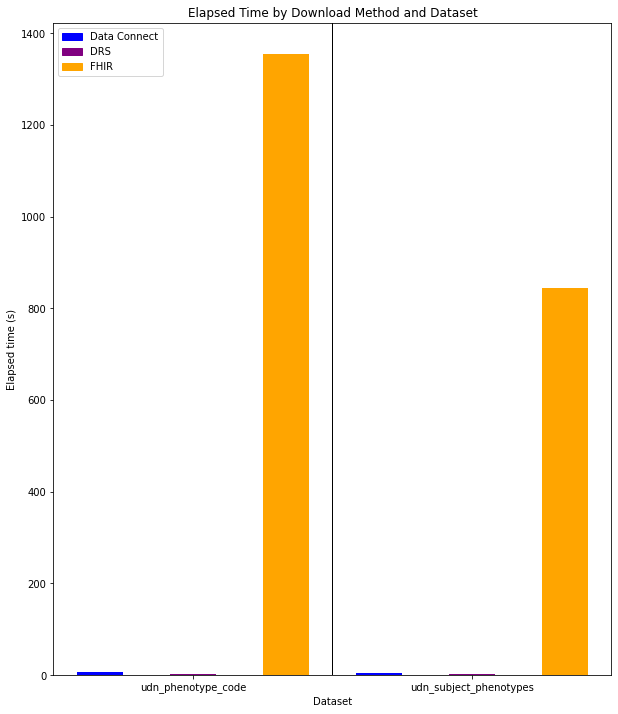

In [43]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

#calculate elapsed time by table and access method
df_groups = plot_df.groupby(['dataset','method'])['elapsed_secs'].mean()

method_colors = {'data_connect': 'blue', 
          'drs': 'purple',
         'fhir': 'orange',
        'fhir-nopassport': 'green'}
# Create legend handles, labels for each group and add legend to the plot
color_list = [method_colors[group[1]] for group in df_groups.keys()]
legend_handles = [
    mpatches.Patch(color=method_colors['data_connect'], label='Data Connect'),
    mpatches.Patch(color=method_colors['drs'], label='DRS'),
    mpatches.Patch(color=method_colors['fhir'], label='FHIR')
]

#create bar plot
ax = df_groups.plot(kind='bar', title='Elapsed Time by Download Method and Dataset',
               ylabel='Elapsed time (s)', xlabel='Dataset', figsize=(10, 12),
              color=color_list)

ax.set_xticks(x)
ax.set_xticklabels(dataset_labels)
plt.xticks(rotation=0)
plt.axvline(x = vline_x, color='black', linewidth=1)
ax.legend(handles=legend_handles,
          loc='upper left')

plt.show()

### Discussion
In achieving the goal of downloading the whole datasets to a dataframe for analysis, Data Connect is significantly faster than the FHIR server. Note that no attempt was made to use advanced query features in FHIR. The aim here was to look at default performance with simple queries, catering to the user who simply wants to ask the question 'get me this dataset'. More advanced features are explored in another notebook.

### How much data is downloaded by each method
Essentially the same data content is downloaded by all three methods. However the three data formats differ in the size of the payload to get that data.

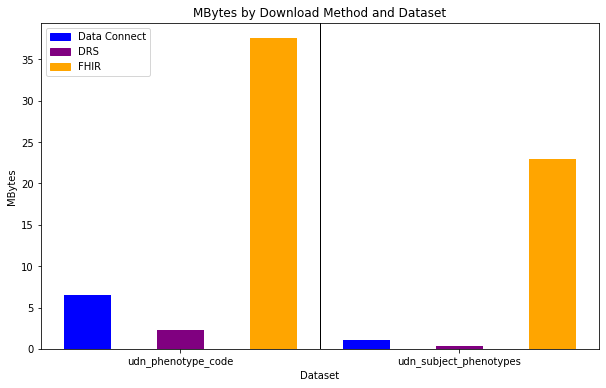

In [47]:
#calculate downloaded bytes by table and access method
df_groups = plot_df.groupby(['dataset','method'])['MBytes'].mean()

color_list = [method_colors[group[1]] for group in df_groups.keys()]# Create legend handles, labels for each group and add legend to the plot
#create bar plot with custom aesthetics
ax = df_groups.plot(kind='bar', title='MBytes by Download Method and Dataset',
               ylabel='MBytes', xlabel='Dataset', figsize=(10, 6),
              color=color_list
              )

ax.set_xticks(x)
ax.set_xticklabels(dataset_labels)
plt.xticks(rotation=0)
#plt.xticks(rotation=45)
plt.axvline(x = vline_x, color='black', linewidth=1)
ax.legend(handles=legend_handles,
          loc='upper left')
plt.show()

### Plot the combined data for both datasets 

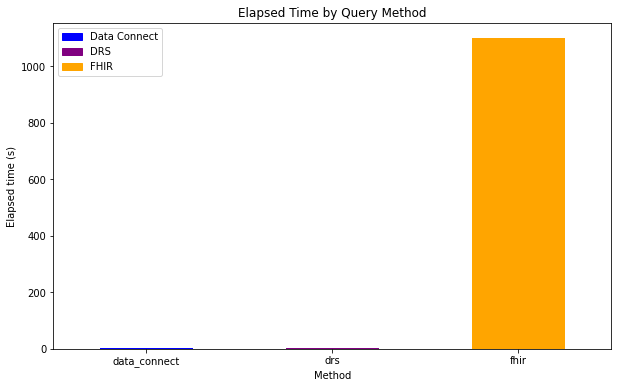

In [50]:
df_groups = plot_df.groupby(['method'])['elapsed_secs'].mean()

color_list = [method_colors[group] for group in df_groups.keys()]
ax = df_groups.plot(kind='bar', title='Elapsed Time by Query Method',
               ylabel='Elapsed time (s)', xlabel='Method', figsize=(10, 6),
              color=color_list)

#rotate x-axis ticks vertically
plt.xticks(rotation=0)
ax.legend(handles=legend_handles,
          loc='upper left')
plt.show()

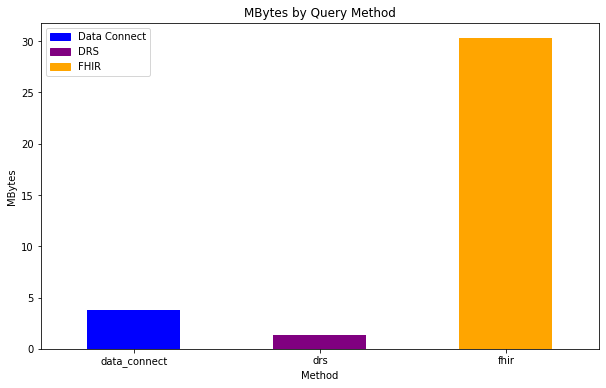

In [52]:
df_groups = plot_df.groupby(['method'])['MBytes'].mean()

color_list = [method_colors[group] for group in df_groups.keys()]
ax = df_groups.plot(kind='bar', title='MBytes by Query Method',
               ylabel='MBytes', xlabel='Method', figsize=(10, 6),
              color=color_list)

plt.xticks(rotation=0)
ax.legend(handles=legend_handles,
          loc='upper left')
plt.show()

In [54]:
plot_df

,method,dataset,elapsed_secs,MBytes
0,drs,udn_phenotype_code,1.7896,2.302886
1,fhir,udn_phenotype_code,1355.3497,37.560506
2,drs,udn_subject_phenotypes,1.6420,0.410126
3,fhir,udn_subject_phenotypes,842.9803,23.011575
4,data_connect,udn_phenotype_code,5.3940,6.514111
5,data_connect,udn_subject_phenotypes,3.8580,1.047662


### Create a summary table of the data volumes for each method
We can now also calculate the relative ratios of the volume the data consumes for each method.

In [56]:
pivoted = plot_df.pivot(index="dataset", columns="method", values="MBytes")
pivoted.to_csv("data/method_datasize_comparisons.txt", sep='\t')
pivoted['fhir_over_drs'] = pivoted['fhir']/pivoted['drs']
pivoted['fhir_over_dc'] = pivoted['fhir']/pivoted['data_connect']
pivoted['dc_over_drs'] = pivoted['data_connect']/pivoted['drs']
pivoted

method,data_connect,drs,fhir,fhir_over_drs,fhir_over_dc,dc_over_drs
dataset,,,,,,
udn_phenotype_code,6.514111,2.302886,37.560506,16.310189,5.766022,2.828673
udn_subject_phenotypes,1.047662,0.410126,23.011575,56.108586,21.964698,2.554489


### Discussion
What is the additional data volume for FHIR?

Examples of each record type for each of the three methods were provided above, but are compared directly below.

In each case, the data for a single udn_phenotype_code record is as follows.

Data Connect records are larger than the single line in the .txt file. FHIR resources have significantly more overhead than the other two methods. This is the main explanation of the higher data volume above.

### DRS - tab delimited .txt file 
(also provided by prefetch)
> ```
> 2181174\t000d9998-d273-4946-88c3-f9946e107e42\tHP:0002020\tno
> ```

Variable names are included once per file as a header line 
> ```
> dbgap_subject_id\tSUBJECT_ID\tHPO_PHENOTYPES\tHPO_OBSERVED_STATUS
> ```

There are also 10 rows of general header information in each file


### Data Connect
> ```json
> {"dbgap_subject_id": 2181174,
>   "subject_id": "000d9998-d273-4946-88c3-f9946e107e42",
>  "hpo_phenotypes": "HP:0002020",
>  "hpo_observed_status": "no"}
> ```

Variable names are included in every record.

Each page returned by the Data Connect server contains a JSON Schema representation of the data model of the data returned. This includes information such as the dbGaP variable id. See discussion of schema below for complete details. Though these table metadata are repeated once per page the overall impact is not high.


### FHIR Condition
    {
       "resourceType": "Condition",
       "id": "cnd-2181175-278114-3551",
       "meta": {
          "versionId": "1",
          "lastUpdated": "2024-09-23T15:16:50.610-04:00",
          "source": "#EDQU8nruHSXHeWea",
          "security": [
             {
                "system": "http://terminology.hl7.org/CodeSystem/v3-Confidentiality",
                "code": "U",
                "display": "unrestricted"
             }
          ]
       },
       "verificationStatus": {
          "coding": [
             {
                "system": "http://hl7.org/fhir/ValueSet/condition-ver-status",
                "code": "confirmed"
             }
          ]
       },
       "code": {
          "coding": [
             {
                "system": "http://human-phenotype-ontology.org",
                "code": "HP:0004322"
             }
          ]
       },
       "subject": {
          "reference": "Patient/2181175"
       }
    }

### FHIR Observation
    {
        "resourceType": "Observation",
        "id": "278121-2753816-0",
        "meta": {
            "versionId": "1",
            "lastUpdated": "2024-09-23T14:50:10.931-04:00",
            "source": "#rnrQ0dSn8j5N1MAH",
            "security": [
                {
                    "system": "http://terminology.hl7.org/CodeSystem/v3-Confidentiality",
                    "code": "U",
                    "display": "unrestricted"
                }
            ]
        },
        "status": "final",
        "code": {
            "coding": [
                {
                    "system": "https://dbgap-api.ncbi.nlm.nih.gov/fhir/x1/CodeSystem/DbGaPConcept-VariableAccession",
                    "code": "phv00278121.v5.p2",
                    "display": "AGE_ONSET"
                }
            ]
        },
        "subject": {
            "reference": "Patient/2753816"
        },
        "valueString": "15"
    }


## 2. Search/query capability
The above considered retrieval of the data in bulk for a single table of data.

Data Connect and FHIR also provide the ability to run SQL queries against the tables, selecting data for only records that match certain criteria.

In this Data Connect example subjects are selected in which a specific phenotype (HPO code) were observed.

In [60]:
cl.run_query('''select * 
             from tutorial.scr_udn_v5.udn_phenotype_code
             where hpo_phenotypes = 'HP:0001263' and hpo_observed_status = 'yes' ''',
             query_tags={'dataset':'udn_phenotype_code_selected'},
             return_type='dataframe')

Retrieving the query
____Waiting1_______________
____Waiting2_______________
____Waiting3_______________
____Waiting4_______________
____Waiting5_______________
____Waiting6_______________
____Waiting7_______________
____Waiting8_______________
____Waiting9_______________
____Data page10_______________
writing log


,dbgap_subject_id,subject_id,hpo_phenotypes,hpo_observed_status
0,2181174,000d9998-d273-4946-88c3-f9946e107e42,HP:0001263,yes
1,3038776,001259d2-bd62-41b1-ae42-ddaa6fe9b134,HP:0001263,yes
2,3038777,004f3173-448e-430c-a77e-566019fd0354,HP:0001263,yes
3,2181175,00d91093-28a9-4133-8b45-fe53d9e8e656,HP:0001263,yes
4,2753257,00f5c870-083d-4f3e-a24d-13d8b5c6c14f,HP:0001263,yes
...,...,...,...,...
1427,2754313,ff4095dc-8dca-4199-ba3a-36fc523385f1,HP:0001263,yes
1428,3040290,ff6e5c36-88db-47d8-b6b7-f59279d452bd,HP:0001263,yes
1429,2754314,ff87190e-d452-4999-9763-0a5a3f1a8595,HP:0001263,yes
1430,1827112,ffd3c14b-28ed-4204-bbe7-35a3066b8ee3,HP:0001263,yes


The equivalent FHIR query is quite straightforward because both attributes in the query are part of the same resource.

In [23]:
query_string = "Condition?code=HP:0001263&verification-status=confirmed"
selected_conditions = mf.run_query(query_string,
            query_tags={'dataset':'udn_phenotype_code_selected'})

Total  Resources: 1432
Total  Bytes: 1399164
Total  Pages: 15
Time elapsed 52.9886 seconds
writing log


### Query on multiple phenotypic variables 

Say we want to find patients by primary symptom category  and affection status.
In Data Connect this query is quite straightforward as values of these attributes for a given subject are in the same row of the original udn_subject_phenotypes table. The following where clause will work.
```
where affection_status = 'A' and primary_symptom_category = '5'
```

Note: the meaning of the codes A and 5 are not clear here. They correspond to 'Affected' and 'Endocrinology' respectively. The section on the table schema below shows how that can be determined.

In [24]:
cl.run_query('''select * from 
tutorial.scr_udn_v5.udn_subject_phenotypes
where affection_status = 'A' and primary_symptom_category = '5' ''',
             return_type='dataframe')

Retrieving the query
____Waiting1_______________
____Waiting2_______________
____Waiting3_______________
____Waiting4_______________
____Waiting5_______________
____Waiting6_______________
____Waiting7_______________
____Data page8_______________
____Data page9_______________
____Data page10_______________
____Data page11_______________
writing log


,dbgap_subject_id,subject_id,sex,race,ethnicity,primary_symptom_category,age_onset,affection_status
0,2181336,74760e06-59a2-42aa-8d98-72409b407765,F,White,Hispanic or Latino,5,8,A
1,3510756,b9a299da-7493-4272-995f-454b7c202d18,F,American Indian or Alaska Native,Not Hispanic or Latino,5,10,A
2,2753360,1a24f1fa-701e-4597-aa97-693899c2a81e,F,White,Not Hispanic or Latino,5,14,A
3,3510147,419e1702-e976-4f02-96fb-9164a2110c1e,F,White,Not Hispanic or Latino,5,19,A
4,3510555,8b37eca1-7292-4891-817d-0e5e0a992cbe,F,White,Unknown/Not Reported Ethnicity,5,39,A
5,4296525,05425c49-b4fa-4a9f-9a75-2ac591915ed2,F,White,N/A,5,41,A
6,2753288,0a9cb7fe-9003-4b0b-9493-2eb155dd7c4d,F,White,N/A,5,51,A
7,4296874,5c269d37-b730-44d1-8e7b-5cd344bd31f0,F,White,Not Hispanic or Latino,5,53,A
8,3509891,0f873fb8-7961-4acd-a063-41a3ee6ac0dd,F,Other,Not Hispanic or Latino,5,56,A
9,3510713,af6feebe-3182-4993-bea6-cbc32aa9efc3,F,White,Not Hispanic or Latino,5,59,A


The equivalent FHIR query is more challenging to create. Each of the two values is a different FHIR Observation. Even where the 'join' of Observations exists the query syntax is not straightforward.

In DataConnect the query was
```where affection_status = 'A' and primary_symptom_category = '5'```

We need to know the codes for these two variables. For now we will just provide them as follows.
* affection_status phv00278122.v5.p2
* primary_symptom_category phv00278120.v5.p2

Building the query step by step...

In [25]:
# Reset the log
query_log = "logs/fhir_expts.json"
mf.query_log = query_log

#### Individual Observation queries
The following two queries are for each Observation separately

In [26]:
query_string = "Observation?code-value-string=phv00278122.v5.p2$A"
ob = mf.run_query(query_string,
            query_tags={'dataset':'udn_phenotype_code_selected'})

Total  Resources: 2096
Total  Bytes: 1964218
Total  Pages: 21
Time elapsed 78.8356 seconds
writing log


In [27]:
query_string = "Observation?code-value-string=phv00278120.v5.p2$5"
ob = mf.run_query(query_string,
            query_tags={'dataset':'udn_phenotype_code_selected'})

Total  Resources: 55
Total  Bytes: 51897
Total  Pages: 1
Time elapsed 5.1982 seconds
writing log


#### Linking via the patient
The two observations are about the same patient - so to associate them we do a reverse chain query

In [28]:
query_string = "Patient?_has:Observation:patient:code-value-string=phv00278122.v5.p2$A"
patient = mf.run_query(query_string,
            query_tags={'dataset':'udn_phenotype_code_selected'})

Total  Resources: 2096
Total  Bytes: 1612320
Total  Pages: 21
Time elapsed 69.9884 seconds
writing log


In [29]:
query_string = "Patient?_has:Observation:patient:code-value-string=phv00278122.v5.p2$A&_has:Observation:patient:code-value-string=phv00278120.v5.p2$5"
patient = mf.run_query(query_string,
            query_tags={'dataset':'udn_phenotype_code_selected'})

Total  Resources: 27
Total  Bytes: 21024
Total  Pages: 1
Time elapsed 1.6394 seconds
writing log


#### Retrieving all the phenotypic attributes
While the above retrieves the patients it does not return the phenotypic attributes.

That can be done using FHIR's \_revinclude syntax.

In [30]:
query_string = "Patient?_revinclude=Observation:subject&_has:Observation:patient:code-value-string=phv00278122.v5.p2$A&_has:Observation:patient:code-value-string=phv00278120.v5.p2$5"
patients_and_observations = mf.run_query(query_string,
            query_tags={'dataset':'udn_phenotype_code_selected'},
                                        debug=False)

Total  Resources: 162
Total  Bytes: 146976
Total  Pages: 1
Time elapsed 2.4529 seconds
writing log


In [31]:
len(patients_and_observations)

162

In [32]:
from collections import Counter
resource_counter = Counter()
for r in patients_and_observations:
    resource_counter[r['resourceType']] +=1
resource_counter   

Counter({'Patient': 27, 'Observation': 135})

In [33]:
with open ("logs/patients_and_observations.json", "w") as f:
    json.dump(patients_and_observations, f, indent=3)

In [34]:
affected_clause= "code-value-string=phv00278122.v5.p2$A"
symptom_clause = "code-value-string=phv00278120.v5.p2$5"

### Queries can treat numbers as numbers

This example in DataConnect selects subjects where the age of onset of the primary symptom was greater than 11.

In [35]:
cl.run_query('''select * from tutorial.scr_udn_v5.udn_subject_phenotypes
where age_onset > 11 ''', return_type='dataframe')

Retrieving the query
____Page1_______________
____Page2_______________
____Page3_______________
____Page4_______________
____Page5_______________
____Page6_______________
____Page7_______________
____Page8_______________
writing log


,dbgap_subject_id,subject_id,sex,race,ethnicity,primary_symptom_category,age_onset,affection_status
0,1827002,3a56a0ba-eedc-4e25-ae31-ce73480fa0b3,F,White,Not Hispanic or Latino,None,12,UA
1,1827099,e647cf1d-c284-4ae6-8bf6-34ec09518991,F,White,Hispanic or Latino,2,12,A
2,2181436,bd6c49c4-6025-437f-88eb-c58f6df0bc23,F,White,Not Hispanic or Latino,22,12,A
3,2181246,3535f4e1-728c-4cd9-b0c2-8a59cfab86e7,F,Asian,Not Hispanic or Latino,20,12,UA
4,2753592,522d0e43-b2b5-406a-a547-12ef185407a2,F,White,Not Hispanic or Latino,12,12,UK
...,...,...,...,...,...,...,...,...
4558,3039893,bc9f9c58-444c-4d1c-bae1-6a98c3069cd3,O,Other,Not Hispanic or Latino,None,80,UA
4559,4296765,40783c2c-33df-405e-b24d-fdb374bbf0dc,O,White,Not Hispanic or Latino,None,80,A
4560,4296845,54ed8e54-59eb-4a18-9aad-db69ff537e27,O,White,Hispanic or Latino,None,96,A
4561,2753902,9a709d2e-7bc6-4f6f-9d62-785ba7f2cf94,O,White,Not Hispanic or Latino,None,101,A


### What is the unit for age? Using the table schema
This might raise the question in the query above whether the value of 11 for the age of onset is 11 years, months, days etc.

Data Connect allows a machine readable schema for each table to be provided as a JSON Schema. With an extension to provide the unit of measure we can see that the unit for age_onset is years.

Codings for enumerated values are also provided.

In this Data Connect implementation an extension was created to produce the schema automatically from information provided by dbGaP submitters. No additional curation was required. Data submitters are required to provide a data dictionary for each of their data tables which is then stored as XML. The extension transforms the XML data dictionary for each dbGaP table to a JSON schema.

The list_table_info method of the DataConnectClient class is a simple wrapper around the /table/\<tablename\>/info endpoint for the Data Connect service.

Note that these schema are also those referred to above as provided (once per page) in table download or query results. 

In [36]:
cl.list_table_info('tutorial.scr_udn_v5.udn_subject_phenotypes', verbose=True)

_Schema for tabletutorial.scr_udn_v5.udn_subject_phenotypes_
{
   "name": "tutorial.scr_udn_v5.udn_subject_phenotypes",
   "data_model": {
      "description": "",
      "$id": "dbgap:pht006079.v5",
      "properties": {
         "SUBJECT_ID": {
            "$id": "dbgap:phv00278116.v5",
            "description": "De-identified subject ID",
            "type": "string"
         },
         "SEX": {
            "$id": "dbgap:phv00278117.v5",
            "description": "Biological sex",
            "type": "encoded value",
            "oneOf": [
               {
                  "const": "F",
                  "title": "Female"
               },
               {
                  "const": "M",
                  "title": "Male"
               },
               {
                  "const": "O",
                  "title": "Other"
               }
            ]
         },
         "RACE": {
            "$id": "dbgap:phv00278118.v5",
            "description": "Race of subject",
          

### Listing codings
A convenience function in the DataConnectClient can be used to show the coding of data in all or specific columns. Here we use it to show the codings in the phenotype query run previously.

In [43]:
prettyprint(cl.get_decode_template('tutorial.scr_udn_v5.udn_subject_phenotypes', 
                       propList=['AFFECTION_STATUS', 'PRIMARY_SYMPTOM_CATEGORY'], 
                       numericCodes=False))

{
   "PRIMARY_SYMPTOM_CATEGORY": {
      "1": "Allergies and Disorders of The Immune System",
      "2": "Cardiology and vascular conditions (heart, artery, vein, and lymph disorders)",
      "3": "Dentistry and craniofacial (bones of head and face)",
      "4": "Dermatology (skin diseases and disorders)",
      "5": "Endocrinology (disorder of the endocrine glands and hormones)",
      "6": "Gastroenterology (disorder of the stomach and intestines)",
      "7": "Gynecology and reproductive medicine",
      "8": "Hematology (blood diseases and disorders)",
      "9": "Infectious diseases",
      "10": "Musculoskeletal and orthopedics (structural and functional disorders of muscles, bones, and joints)",
      "11": "Nephrology (kidney diseases and disorders)",
      "12": "Neurology (disorders of the nervous system, including brain and spinal cord)",
      "13": "Oncology (Tumors and cancer)",
      "14": "Ophthalmology (Eye disorders and diseases)",
      "15": "Psychiatry",
      "16"

##Combining dbGaP data with other sources

### Query SRA 'metadata' for a UDN sample

Other data sources can also be made available through Data Connect from their original source.

It was straightfoward to make available via Data Connect the SRA metadata table that NCBI provides in BigQuery.

#### Query run data for a UDN sample

In this case we can illustrate the use of a an interactive 

In [43]:
query1 = '''SELECT assay_type, experiment, instrument, librarysource, avgspotlen
FROM \"nih-sra-datastore\".sra.metadata
where acc='SRR29721791'
'''

res = cl.run_query(query1, return_type='dataframe', )
res

Retrieving the query
____Waiting1_______________
____Waiting2_______________
____Waiting3_______________
____Waiting4_______________
____Waiting5_______________
____Waiting6_______________
____Waiting7_______________
____Waiting8_______________
____Waiting9_______________
____Waiting10_______________
____Waiting11_______________
____Waiting12_______________
____Waiting13_______________
____Waiting14_______________
____Waiting15_______________
____Data page16_______________
____Data page17_______________
____Data page18_______________
____Data page19_______________
____Data page20_______________
writing log


,assay_type,experiment,instrument,librarysource,avgspotlen
0,RNA-Seq,SRX25223969,NextSeq 550,TRANSCRIPTOMIC,255


In [38]:
json_data = cl.get_data('tutorial.scr_udn_v5.sra_run_flat', return_type='json')
                        #query_tags=query_tags )
df = pd.DataFrame.from_dict(json_data)
df

Retrieving the query
____Waiting1_______________
____Waiting2_______________
____Waiting3_______________
____Waiting4_______________
____Waiting5_______________
____Waiting6_______________
____Waiting7_______________
____Waiting8_______________
____Waiting9_______________
____Waiting10_______________
____Data page11_______________
____Data page12_______________
____Data page13_______________
____Data page14_______________
____Data page15_______________
____Data page16_______________
____Data page17_______________
writing log


,acc,assay_type,center_name,consent,experiment,sample_name,instrument,librarylayout,libraryselection,librarysource,...,gap_accession_sam,molecular_data_type_sam,phs,run_file_create_date,sex_calc,study_design_sam,study_disease_sam,study_name_sam,subject_is_affected_sam,submitted_subject_id_sam
0,SRR29597116,RNA-Seq,HMS-CC,GRU,SRX25103284,e2be8e51-f3ec-4131-a76f-8bb1f95bbc15,NextSeq 550,PAIRED,RANDOM,TRANSCRIPTOMIC,...,phs001232,None,phs001232.c1,2024-06-27T01:58:00.000Z,male,Prospective Longitudinal Cohort,None,Clinical and Genetic Evaluation of Individuals...,None,d1c1e140-7546-4538-bf00-60f448680fb5
1,SRR13431770,RNA-Seq,HMS-CC,GRU,SRX9844751,4eac7bf4-51c8-4b06-8ccf-7cd9c598f146,NextSeq 550,PAIRED,RANDOM,GENOMIC,...,phs001232,None,phs001232.c1,2021-01-14T04:40:00.000Z,male,Prospective Longitudinal Cohort,None,Clinical and Genetic Evaluation of Individuals...,None,bfce04c1-50ee-4bcc-b647-675f1790374d
2,SRR29730944,RNA-Seq,HMS-CC,GRU,SRX25233100,41a53027-2e8b-46a9-9db6-1f332961233a,NextSeq 550,PAIRED,RANDOM,TRANSCRIPTOMIC,...,phs001232,None,phs001232.c1,2024-07-08T04:52:00.000Z,male,Prospective Longitudinal Cohort,None,Clinical and Genetic Evaluation of Individuals...,None,9b255abb-09d6-4c3c-b868-80710b9d4dfc
3,SRR22091259,RNA-Seq,HMS-PHS001232,GRU,SRX18071464,cb340351-4ed3-48c0-b456-48d2758c4b46,NextSeq 550,PAIRED,RANDOM,TRANSCRIPTOMIC,...,phs001232,None,phs001232.c1,2022-10-28T20:34:00.000Z,male,Prospective Longitudinal Cohort,None,Clinical and Genetic Evaluation of Individuals...,None,831d27f7-ef73-4ca0-ab9f-1c00cb902d87
4,SRR13431808,RNA-Seq,HMS-CC,GRU,SRX9846186,9e102712-2125-4567-b1d0-4645d7f5c4f6,NextSeq 550,PAIRED,RANDOM,GENOMIC,...,phs001232,None,phs001232.c1,2021-01-14T22:48:00.000Z,male,Prospective Longitudinal Cohort,None,Clinical and Genetic Evaluation of Individuals...,None,eacedac0-e79f-49a5-99da-7964e53b5be1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10028,SRR29597105,RNA-Seq,HMS-CC,GRU,SRX25103273,b29fac1f-6f21-442b-937f-8345239ffcbd,NextSeq 550,PAIRED,RANDOM,TRANSCRIPTOMIC,...,phs001232,None,phs001232.c1,2024-06-27T02:27:00.000Z,female,Prospective Longitudinal Cohort,Rare Diseases,Clinical and Genetic Evaluation of Individuals...,True,cf0e0e1f-5aad-4896-9267-56913e53a6a1
10029,SRR29667123,RNA-Seq,HMS-CC,GRU,SRX25170715,043d6435-c3a4-489f-8f61-944b3ef9f868,NextSeq 550,PAIRED,RANDOM,TRANSCRIPTOMIC,...,phs001232,None,phs001232.c1,2024-07-01T18:08:00.000Z,female,Prospective Longitudinal Cohort,Rare Diseases,Clinical and Genetic Evaluation of Individuals...,True,effa0b75-c20e-4fe3-9816-994baeb85bd4
10030,SRR29721791,RNA-Seq,HMS-CC,GRU,SRX25223969,db08ba64-ac0b-4420-865c-db805f177847,NextSeq 550,PAIRED,RANDOM,TRANSCRIPTOMIC,...,phs001232,None,phs001232.c1,2024-07-06T08:56:00.000Z,female,Prospective Longitudinal Cohort,Rare Diseases,Clinical and Genetic Evaluation of Individuals...,True,d09b29ac-c259-4412-a3bf-ddd822601934
10031,SRR29726320,RNA-Seq,HMS-CC,GRU,SRX25228479,80019a20-b265-4c49-9d0e-a15609d30b25,NextSeq 550,PAIRED,RANDOM,TRANSCRIPTOMIC,...,phs001232,None,phs001232.c1,2024-07-07T01:32:00.000Z,female,Prospective Longitudinal Cohort,Rare Diseases,Clinical and Genetic Evaluation of Individuals...,True,e80737b1-2232-4f40-853d-0035d973ae72


In [44]:
query1 = '''SELECT assay_type, experiment, instrument, librarysource, avgspotlen
FROM tutorial.scr_udn_v5.sra_run_flat
where acc='SRR29721791'
'''

res = cl.run_query(query1, return_type='dataframe', )
res

Retrieving the query
____Waiting1_______________
____Waiting2_______________
____Waiting3_______________
____Waiting4_______________
____Waiting5_______________
____Waiting6_______________
____Waiting7_______________
____Waiting8_______________
____Data page9_______________
____Data page10_______________
____Data page11_______________
____Data page12_______________
____Data page13_______________
____Data page14_______________
____Data page15_______________
____Data page16_______________
writing log


,assay_type,experiment,instrument,librarysource,avgspotlen
0,RNA-Seq,SRX25223969,NextSeq 550,TRANSCRIPTOMIC,255.0


In [67]:
json_data = cl.get_data('tutorial.scr_udn_v5.sra_run', return_type='json')
                        #query_tags=query_tags )
df = pd.DataFrame.from_dict(json_data)
df

Retrieving the query
____1-Waiting_______________
____2-Waiting_______________
____3-Waiting_______________
____4-Waiting_______________
____5-Waiting_______________
____6-Waiting_______________
____7-Waiting_______________
____8-Waiting_______________
____9-Waiting_______________
____10-Retrieving results_______________
____11-Retrieving results_______________
____12-Retrieving results_______________
____13-Retrieving results_______________
____14-Retrieving results_______________
____15-Retrieving results_______________
____16-Retrieving results_______________
____17-Retrieving results_______________
____18-Retrieving results_______________
____19-Retrieving results_______________
____20-Retrieving results_______________
____21-Retrieving results_______________
____22-Retrieving results_______________
____23-Retrieving results_______________
____24-Retrieving results_______________
____25-Retrieving results_______________
writing log


,acc,assay_type,center_name,consent,experiment,sample_name,instrument,librarylayout,libraryselection,librarysource,...,geo_loc_name_sam,ena_first_public_run,ena_last_update_run,sample_name_sam,datastore_filetype,datastore_provider,datastore_region,attributes,run_file_version,jattr
0,SRR6132783,WGS,HMS-CC,GRU,SRX3227361,be5cdb0a-4d49-476d-8078-08bf9e55f2a3,Illumina HiSeq 2500,PAIRED,RANDOM,GENOMIC,...,[],[],[],[],"[bam, run.zq, sra]","[gs, ncbi, s3]","[gs.us-east1, ncbi.dbgap, s3.us-east-1]","[{'k': 'alignment_software_exp', 'v': 'BWA-mem...",1,"{""alignment_software_exp"": ""BWA-mem v0.7.12"", ..."
1,SRR6132807,WGS,HMS-CC,GRU,SRX3227361,be5cdb0a-4d49-476d-8078-08bf9e55f2a3,Illumina HiSeq 2500,PAIRED,RANDOM,GENOMIC,...,[],[],[],[],"[bam, run.zq, sra]","[gs, ncbi, s3]","[gs.us-east1, ncbi.dbgap, s3.us-east-1]","[{'k': 'alignment_software_exp', 'v': 'BWA-mem...",1,"{""alignment_software_exp"": ""BWA-mem v0.7.12"", ..."
2,SRR6132779,WGS,HMS-CC,GRU,SRX3245071,f9cbab59-a953-4a68-bee2-1590e15e7f85,Illumina HiSeq 2500,PAIRED,RANDOM,GENOMIC,...,[],[],[],[],"[bam, run.zq, sra]","[gs, ncbi, s3]","[gs.us-east1, ncbi.dbgap, s3.us-east-1]","[{'k': 'alignment_software_exp', 'v': 'BWA-mem...",1,"{""alignment_software_exp"": ""BWA-mem v0.7.12"", ..."
3,SRR6112521,WGS,HMS-CC,GRU,SRX3245071,f9cbab59-a953-4a68-bee2-1590e15e7f85,Illumina HiSeq 2500,PAIRED,RANDOM,GENOMIC,...,[],[],[],[],"[bam, run.zq, sra]","[gs, ncbi, s3]","[gs.us-east1, ncbi.dbgap, s3.us-east-1]","[{'k': 'alignment_software_exp', 'v': 'BWA-mem...",1,"{""alignment_software_exp"": ""BWA-mem v0.7.12"", ..."
4,SRR10439634,WGS,HMS-CC,GRU,SRX7135320,f7a847ab-1200-426b-9b73-bd631742f493,Illumina HiSeq 2500,PAIRED,RANDOM,GENOMIC,...,[],[],[],[],"[run.zq, source, sra]","[gs, ncbi, s3]","[gs.us-east1, ncbi.dbgap, s3.us-east-1]","[{'k': 'alignment_software_exp', 'v': 'BWA-mem...",1,"{""alignment_software_exp"": ""BWA-mem v0.7.12"", ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10028,SRR29725314,RNA-Seq,HMS-CC,GRU,SRX25227473,a4755e79-ff10-4676-82df-edefa520388a,NextSeq 550,PAIRED,RANDOM,TRANSCRIPTOMIC,...,[],[],[],[],"[bam, run.zq, sra]","[gs, ncbi, s3]","[gs.us-east1, ncbi.dbgap, s3.us-east-1]","[{'k': 'alignment_software_exp', 'v': 'STAR'},...",1,"{""alignment_software_exp"": ""STAR"", ""sex_calc"":..."
10029,SRR29726320,RNA-Seq,HMS-CC,GRU,SRX25228479,80019a20-b265-4c49-9d0e-a15609d30b25,NextSeq 550,PAIRED,RANDOM,TRANSCRIPTOMIC,...,[],[],[],[],"[bam, run.zq, sra]","[gs, ncbi, s3]","[gs.us-east1, ncbi.dbgap, s3.us-east-1]","[{'k': 'alignment_software_exp', 'v': 'STAR'},...",1,"{""alignment_software_exp"": ""STAR"", ""sex_calc"":..."
10030,SRR29729274,RNA-Seq,HMS-CC,GRU,SRX25231430,55bc3aea-4eb2-42ce-831d-ecd4080527a3,NextSeq 550,PAIRED,RANDOM,TRANSCRIPTOMIC,...,[],[],[],[],"[bam, run.zq, sra]","[gs, ncbi, s3]","[gs.us-east1, ncbi.dbgap, s3.us-east-1]","[{'k': 'alignment_software_exp', 'v': 'STAR'},...",1,"{""alignment_software_exp"": ""STAR"", ""sex_calc"":..."
10031,SRR29730939,RNA-Seq,HMS-CC,GRU,SRX25233095,577027d8-82a5-4b41-9a30-7b4e2112a044,NextSeq 550,PAIRED,RANDOM,TRANSCRIPTOMIC,...,[],[],[],[],"[bam, run.zq, sra]","[gs, ncbi, s3]","[gs.us-east1, ncbi.dbgap, s3.us-east-1]","[{'k': 'alignment_software_exp', 'v': 'STAR'},...",1,"{""alignment_software_exp"": ""STAR"", ""sex_calc"":..."


### Schema for SRA metadata

While no machine readable schema was available for the SRA metadata table it was straightforward to create one based on the information made available at

https://www.ncbi.nlm.nih.gov/sra/docs/sra-cloud-based-metadata-table/

Data Connect provides a standard for providing schema for data (such as SRA) that is unlikely to be provided in FHIR.

In [69]:
cl.list_table_info('nih_sra_datastore.sra.metadata', verbose=True)

_Schema for tablenih_sra_datastore.sra.metadata_
{
   "name": "nih_sra_datastore.sra.metadata",
   "description": "Metadata Table (sra.metadata) contains information about the run and biological samples. Metadata Table (sra.metadata) contains information about the run and biological samples. The biological sample data is stored in two different columns.  See Record (array) column that you need to use the command UNNEST to query. See https://www.ncbi.nlm.nih.gov/sra/docs/sra-cloud-based-metadata-table/",
   "data_model": {
      "$id": "",
      "description": "Metadata Table (sra.metadata) contains information about the run and biological samples. Metadata Table (sra.metadata) contains information about the run and biological samples. The biological sample data is stored in two different columns.  See Record (array) column that you need to use the command UNNEST to query. See https://www.ncbi.nlm.nih.gov/sra/docs/sra-cloud-based-metadata-table/",
      "$schema": "http://json-schema.or